<h2><center> The Effects of Spatial Agglomeration on Relative Net Profitability: a prospective look at Seoul’s retail market sector using machine learning </center></h2>

# Introduction

 Stakeholders looking to open new businesses will often dispute which part of a city they should open in. The rise of specialized localities in Seoul has made this decision process harder since entrepreneurs now have to decide whether to open business in a fiercely competitive neighborhood or risk defaulting in a less famous location. Thus, this research will use Seoul’s retail markets to assess whether clustering markets holds an inherent economic advantage over individual markets.
 
 In particular, this research will mainly focus on restaurants, cafe's, and late-night food stores (such as chicken or pizza).

## Definitions

- **Retail Type**: is defined by a certain types of retail stores that share characteristics with other stores. This will be found using the unsupervised K-means algorithm. The focus of this research will be mainly on food and drinks.

- **Cluster**: Using DBSCAN clustering algorithms, I will find the locations in which stores of the same *retail type* are clustered together while others of the same *retail type* are considered *outliers* based on the algorithm.


## Data

Based on the definition of our problem, some factors that will influence our discussion are:
- locations of popular districts in the city of Seoul
- types of retail stores, may it be cafe's restauraunts, conveinence stores, etc.


# Research

Before we begin, let's import all the necessary libraries for this project:

In [1]:
# Exporatory Data Analysis
import pandas as pd
import numpy as np

# Url requests & parse
import urllib.request, requests
from bs4 import BeautifulSoup

# Data Visualization
import matplotlib.pyplot as plt
import folium

# File Management
import re, os, sys
import json
from pandas.io.json import json_normalize
import pickle

In [2]:
# Helper function to retrieve large data files
def retrieve_dataframe(files) -> bool:
    # Returns True if pickled data returns. False if not pickled
    try:
        for i in range(len(files)):
            string = 'Data/'+files[i]
            temp = pd.read_pickle(string)
        print('Dataframes loaded from memory')
        return True
    except:
        print('Dataframes not in memory')
        return False

## Retrieve Locations of Interest

Here, I will create a function that will utilize Kakao's map API to return *latitude* and *longitude* coordinates based on the centroids of our candidate neighborhoods. The function calls a REST API that communicates with Kakao map's servers and returns a json file containing information about the query. Here, since I am only interested in the specific location, I will return only the coordinates.

Eventually, these coordinates will give us an area where we will run K-means clustering algorithms to find the *types* of stores using their most defining characteristics.

In [3]:
Kakao_appkey = 'KakaoAK 1dd987b2b0f2925d8b7ea121281310c8'

def getLatLng(addr):
    url = 'https://dapi.kakao.com/v2/local/search/address.json?query='+addr
    headers = {"Authorization": Kakao_appkey}
    result = json.loads(str(requests.get(url,headers=headers).text))
    try:
        match_first = result['documents'][0]['address']
        return float(match_first['y']),float(match_first['x'])
    except IndexError:
        print("Not documented in API")
        
    return None

def queryAddress(query, lat='37.5665', lng='126.9780', radius='20000'):
    # This function will return the locations with query within a radius of this.radius meters (default 20km)
    # Default coordinates centered in Seoul
    url = 'https://dapi.kakao.com/v2/local/search/keyword.json?y={}&x={}&radius={}&query={}'.format(lat, lng, radius, query)
    headers = {"Authorization": Kakao_appkey}
    result = json.loads(str(requests.get(url,headers=headers).text))
    try:
        return float(result['documents'][0]['y']), float(result['documents'][0]['x'])
    except IndexError:
        return None

Seoul_lat, Seoul_lng = getLatLng("서울")

Now that we have a function for returning the coordinates of a specific address, let's use an excel file containing all the subway stations and create a DataFrame.

**Note**: *We are doing this assuming that the area surrounding the subway stations are usually neighborhoods of high interest*

In [4]:
df = pd.read_excel("Data/subwayStationNames.xlsx")
df = df.drop(['연번', '한자', '중국어', '일본어'], axis=1)
df.head(3)

호선   역명             영문
0  1호선  서울역  Seoul Station
1  1호선   시청      City Hall
2  1호선   종각        Jonggak

Next, we find the locations for each of the stations and use the above functions to find the coordinates and append to the DataFrame. At the same time, we drop any row in our DataFrame that contains locations that are not within a 20km radius based on the center of Seoul.

In [5]:
# First store the station names in query format in an array
stations = []

for idx in df.index:
    name = (''.join(df['역명'][idx].split(' '))).split('(', 1)[0]
    if name[-1] != '역':
        name = name + '역'
    stations.append(name)

# Then we iterate over the array and find the coordinates for each element

station_lat = []
station_lng = []

for idx in range(len(stations)):
    try:
        lat, lng = queryAddress(stations[idx])
        station_lat.append(lat)
        station_lng.append(lng)
    except TypeError:
        print("{} not found within map radius".format(stations[idx]))
        df.drop([idx], axis=0, inplace=True) # drop the row containing unneeded locations
    

df['Latitude'] = station_lat
df['Longitude'] = station_lng
df = df.reset_index()

삼산체육관역 not found within map radius
굴포천역 not found within map radius
부평구청역 not found within map radius
남한산성입구역 not found within map radius
단대오거리역 not found within map radius
신흥역 not found within map radius


Finally let's clean up our DataFrame so that it is ready to be used for our analysis

In [6]:
df = df.drop(['index'], axis=1)
df = df.rename(columns={'호선': 'LineNumber', '역명' : 'StationKor', '영문' : 'StationEng'})
df.head()

LineNumber StationKor       StationEng   Latitude   Longitude
0        1호선        서울역    Seoul Station  37.554679  126.970607
1        1호선         시청        City Hall  37.565344  126.977199
2        1호선         종각          Jonggak  37.570229  126.983152
3        1호선       종로3가  Jongno 3(sam)ga  37.570421  126.992153
4        1호선       종로5가    Jongno 5(o)ga  37.570976  127.001539

Now that we have all the locational data for our neighborhoods, let's visualize the data:

- Seoul center location
- Candidate neighborhoods based upon proximity to stations

In [7]:
map_Seoul = folium.Map(location=[Seoul_lat, Seoul_lng], zoom_start=12)
for index, row in df.iterrows():
    label = '{}, {}'.format(row[1], row[0])
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [row[3], row[4]],
        radius=3,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#333333',
        fill_opacity=0.7,
        parse_html=False
    ).add_to(map_Seoul)

map_Seoul

## Data Exploration

Now that we have our neighborhoods, we can use either Kakao's inherent search API to find the nearest retail stores of interest, or we can also use FourSquare's API to accomplish the same task. In my research, I will use FoureSquare's venue API to look specifically for restauraunts, cafe's and late-night food stores.

### Nearby retail stores using FourSquare API

Foursquare credentials are in the cell below

In [8]:
CLIENT_ID = 'RHLWHDGP2UUV5VAZOUNVEZOC3G5WQ00DPXYVYQIZIQ1BUY1G' # your Foursquare ID
CLIENT_SECRET = 'DAMEJ4SSMIYJ2UXOBS1I33K1DR0VG42RGQHTLBKKZSKPLRZZ' # your Foursquare Secret
VERSION = '20200228' # Foursquare API version

Create a "filter" of sorts that will find which type of restaurant a certain venue is.

In [9]:
food_category = '4d4b7105d754a06374d81259' # 'Root' category for all food-related venues

korean_restaurant_categories = [
    '4bf58dd8d48988d113941735','56aa371be4b08b9a8d5734e4','56aa371be4b08b9a8d5734f0',
    '56aa371be4b08b9a8d5734e7','56aa371be4b08b9a8d5734ed','56aa371be4b08b9a8d5734ea',
    '52af0bd33cf9994f4e043bdd','4bf58dd8d48988d145941735','4bf58dd8d48988d111941735',
    '55a59bace4b013909087cb24','55a59bace4b013909087cb15','55a59bace4b013909087cb27',
    '4bf58dd8d48988d1d2941735','55a59bace4b013909087cb2a','4bf58dd8d48988d1d1941735',
    '4bf58dd8d48988d149941735','4bf58dd8d48988d14a941735','4bf58dd8d48988d1df931735',
    '52e81612bcbc57f1066b79f4','4bf58dd8d48988d16c941735','4bf58dd8d48988d108941735',
    '4bf58dd8d48988d109941735','52e81612bcbc57f1066b7a05','4bf58dd8d48988d10c941735',
    '52e81612bcbc57f1066b79ff','4bf58dd8d48988d10f941735','4bf58dd8d48988d110941735',
    '4bf58dd8d48988d1c1941735','4bf58dd8d48988d153941735','4bf58dd8d48988d151941735',
    '4bf58dd8d48988d1c4941735','4bf58dd8d48988d1ce941735','4bf58dd8d48988d1cc941735',
    '56aa371be4b08b9a8d573538','4bf58dd8d48988d1d3941735'
]
# Further research can also yield the best places to open a bar

cafe_categories = [
    '4bf58dd8d48988d1dc931735','4bf58dd8d48988d1c5941735','4bf58dd8d48988d1bd941735','4bf58dd8d48988d112941735',
    '4bf58dd8d48988d148941735','52e81612bcbc57f1066b7a0a','5744ccdfe4b0c0459246b4e2','4bf58dd8d48988d1c9941735',
    '512e7cae91d4cbb4e5efe0af','4bf58dd8d48988d1bc941735','4bf58dd8d48988d1d0941735','4bf58dd8d48988d146941735',
    '4bf58dd8d48988d1e0931735','4bf58dd8d48988d16d941735','52e81612bcbc57f1066b7a0c','4bf58dd8d48988d16a941735',
    '4bf58dd8d48988d179941735', '4bf58dd8d48988d143941735','4bf58dd8d48988d14f941735'
]

late_night_categories = [
    '52e81612bcbc57f1066b7a06','4bf58dd8d48988d1ca941735','4bf58dd8d48988d14c941735','4d4ae6fc7a7b7dea34424761'
]

Now, implement functions required to filter the data and GET the venues using the API.

In [10]:
# Use the filters I defined above to categorize the venue into either a restauraunt, cafe, or late night joint
def is_venue(categories, specific_filter=None):
    specific = False
    for c in categories:
        category_id = c[1]
        if not(specific_filter is None) and (category_id in specific_filter):
            specific = True
    return specific

def get_categories(categories):
    return [(a['name'], a['id']) for a in categories]

def getNearbyVenues(lat, lon, category, radius, limit=100):
    url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&categoryId={}&radius={}&limit={}'.format(
        CLIENT_ID, CLIENT_SECRET, VERSION, lat, lon, category, radius, limit)
    #url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    #CLIENT_ID, CLIENT_SECRET, VERSION, lat, lon, radius, limit)
    results = requests.get(url).json()['response']['groups'][0]['items']
    venues = [(item['venue']['id'],
                item['venue']['name'],
                get_categories(item['venue']['categories']),
                (item['venue']['location']['lat'], item['venue']['location']['lng']),
                item['venue']['location']['formattedAddress'][0]) for item in results]        
    return venues

def createTable(names, lats, lngs, radius=500):
    restaurants = {}
    korean_restaurants = {}
    cafes = {}
    night_snacks = {}
    all_venues = []
    print("loading data", end=' ')
    for name, lat, lon in zip(names, lats, lngs):
        venues = getNearbyVenues(lat, lon, food_category, radius)
        area = []
        for venue in venues:
            venue_id = venue[0]
            venue_name = venue[1]
            venue_categories = venue[2]
            venue_coord = venue[3]
            venue_address = venue[4]
            restaurant = (name, venue_categories[0][0], venue_name, venue_coord[0], venue_coord[1], venue_address)
            area.append(restaurant)
            restaurants[venue_id] = restaurant
            
            if is_venue(venue_categories, specific_filter=korean_restaurant_categories):
                korean_restaurants[venue_id] = restaurant
            elif is_venue(venue_categories, specific_filter=cafe_categories):
                cafes[venue_id] = restaurant
            elif is_venue(venue_categories, specific_filter=late_night_categories):
                night_snacks[venue_id] = restaurant
        if len(area) == 0:
            area.append((name, 'none', 'none', 'none', 'none', 'none'))
        all_venues.append(area)
        print('.', end='')
    print('\nFinished loading data.')
    return restaurants, korean_restaurants, cafes, night_snacks, all_venues

Now we just need to load all of our data into the main memory. Then, once we have our data, we can create new DataFrames using the dictionaries created.

In [11]:
loaded = retrieve_dataframe(['df_all.pkl', 'df_korean.pkl', 'df_cafes.pkl', 'df_night.pkl'])
if not loaded:
    restaurants, korean_restaurants, cafes, night_snacks, all_venues = createTable(df['StationKor'], df['Latitude'], df['Longitude'])
    df_all = pd.DataFrame.from_dict(restaurants).transpose().reset_index().drop(['index'], axis=1)
    df_all.to_pickle('Data/df_all.pkl')
    
    df_korean = pd.DataFrame.from_dict(korean_restaurants).transpose().reset_index().drop(['index'], axis=1)
    df_korean.to_pickle('Data/df_korean.pkl')
    
    df_cafes = pd.DataFrame.from_dict(cafes).transpose().reset_index().drop(['index'], axis=1)
    df_cafes.to_pickle('Data/df_cafes.pkl')
    
    df_night = pd.DataFrame.from_dict(night_snacks).transpose().reset_index().drop(['index'], axis=1)
    df_night.to_pickle('Data/df_night.pkl')
elif loaded:
    df_all = pd.read_pickle('Data/df_all.pkl')
    df_korean = pd.read_pickle('Data/df_korean.pkl')
    df_cafes = pd.read_pickle('Data/df_cafes.pkl')
    df_night = pd.read_pickle('Data/df_night.pkl')

df_all.head()

Dataframes loaded from memory


0                  1                           2        3  \
0         서울역               Café  THE HOUSE 1932 (더하우스 1932)  37.5555   
1         서울역  Korean Restaurant                      금자네생등심  37.5574   
2         서울역             Bakery      Paris Baguette (파리바게뜨)   37.555   
3         서울역  French Restaurant               Seasons (시즌즈)  37.5552   
4  충정로(경기대입구)   Ramen Restaurant                        유즈라멘  37.5569   

         4                   5  
0  126.967           만리재로35길 5  
1  126.972         중구 통일로 22-4  
2  126.972  중구 통일로 1 (PB서울역사점)  
3  126.975           중구 소월로 50  
4  126.968         중구 만리재로 217

## K-Means Clustering the Data

Now that we have our data and retail stores in Seoul, we can quickly run a K-Means algorithm to cluster our data. The following code will train our data with various *k* values in order to find the optimal *k*.

Since the purpose of this research is to see how clustering affects a store's ability to earn money, we start clustering the stores based on their retail type relative to the nearby station in which they are located.

### One-Hot Encoding the DataFrames

In order to implement a K-Means algorithm on the DataFrames, we need to first apply one-hot encoding on the DataFrames. The following function will take in a DataFrame as input and output a DataFrame that is one-hot encoded.

In [12]:
def one_hot_encode(dataframe):
    # one hot encoding
    onehot = pd.get_dummies(dataframe[[1]], prefix="", prefix_sep="")
    
    # add defining features back to the one hot dataframe
    onehot[['Neighborhood', 'Latitude', 'Longitude']] = dataframe[[0,3,4]]
    
    # move the defining columns back to the first three columns of the dataframe
    fixed_columns = [onehot.columns[-3],onehot.columns[-2],onehot.columns[-1]] + list(onehot.columns[:-3])
    onehot = onehot[fixed_columns]
    
    # return the one hot encoded DataFrame
    return onehot

all_grouped = one_hot_encode(df_all).groupby('Neighborhood').mean().reset_index()
korean_grouped = one_hot_encode(df_korean).groupby('Neighborhood').mean().reset_index()
cafes_grouped = one_hot_encode(df_cafes).groupby('Neighborhood').mean().reset_index()
night_grouped = one_hot_encode(df_night).groupby('Neighborhood').mean().reset_index()

### K-Means Clustering

In order to cluster our data, we first need to find the optimal *k* for the number of clusters we should create. This is done by utilizing the **elbow test** where we plot the sum of squared distances from individual points to its respective cluster centroids. The implementation is shown below.

In [13]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler

def transform_data(data):
    # Normalizes the data
    mms = MinMaxScaler()
    mms.fit(data)
    return mms.transform(data)

def plot_optimal_elbow(data):
    """
    Note: make sure that the data parameter contains *normalized* data
    """
    # Fit to model and append to array
    Sum_of_squared_distances = []
    K = range(1,31)
    for k in K:
        km = KMeans(n_clusters=k)
        km = km.fit(data)
        Sum_of_squared_distances.append(km.inertia_)
    
    return K, Sum_of_squared_distances
    

def helper_fix_dataframe(dataframe, labels, from_dataframe):
    df = dataframe
    df.insert(0, 'Cluster', labels)
    df.insert(0, 'Name', from_dataframe[2])
    df.insert(0, 'Type', from_dataframe[1])
    df.insert(0, 'Station', from_dataframe[0])
    
    df = df[['Station', 'Type', 'Name', 'Cluster', 'Latitude', 'Longitude']]
    return df

def K_means_cluster(kclusters, dataframe):
    # Set number of clusters with the kclusters argument
    cluster = dataframe.drop('Neighborhood', 1)
    kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(cluster)
    
    merged_df = pd.DataFrame()
    merged_df['Cluster Label'] = kmeans.labels_
    merged_df['Station'] = dataframe['Neighborhood']
    
    merged = df
    merged = merged.join(merged_df.set_index('Station'), on='StationEng').dropna()
    
    return merged

**Find the optimal *k* for all the DataFrames**:

Using the Elbow Method, we can find the optimal number of *k* for each of our dataframes. We will find the *k*s using the below graphs.

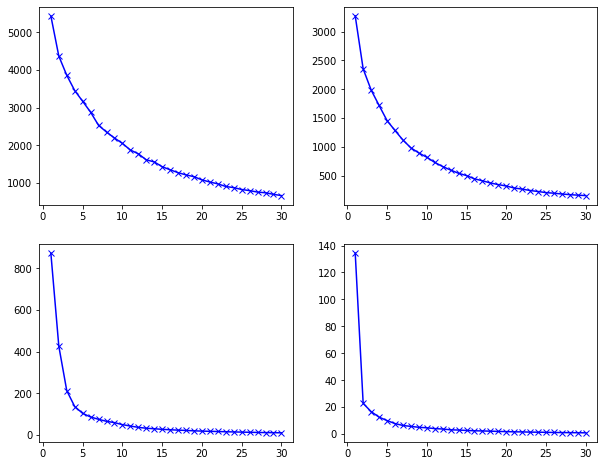

In [14]:
figure, axes = plt.subplots(nrows=2, ncols=2)

all_ungrouped = one_hot_encode(df_all).drop('Neighborhood', 1)
K0, SSD0 = plot_optimal_elbow(transform_data(all_ungrouped))
axes[0, 0].plot(K0, SSD0, 'bx-')

# all
# We can see in the below graph that the optimal k is around 15

korean_ungrouped = one_hot_encode(df_korean).drop('Neighborhood', 1)
K1, SSD1 = plot_optimal_elbow(transform_data(korean_ungrouped))
axes[0, 1].plot(K1, SSD1, 'bx-')

# korean restaurants
# We can see in the below graph that the optimal k is around 15

cafe_ungrouped = one_hot_encode(df_cafes).drop('Neighborhood', 1)
K2, SSD2 = plot_optimal_elbow(transform_data(cafe_ungrouped))
axes[1, 0].plot(K2, SSD2, 'bx-')

# cafes
# We can see in the below graph that the optimal k is close to 5

night_ungrouped = one_hot_encode(df_night).drop('Neighborhood', 1)
K3, SSD3 = plot_optimal_elbow(transform_data(night_ungrouped))
axes[1, 1].plot(K3, SSD3, 'bx-')

# night restaurants
# We can see in the below graph that the optimal k is around 2


figure.set_figheight(8)
figure.set_figwidth(10)

Now that we have our *k* values for each of our DataFrames, we can train our data sets using these values.
Then, we use a helper function to clean the resulting data.

In [15]:
# Train the datasets

kmeans_all = KMeans(n_clusters=15, random_state=0).fit(transform_data(all_ungrouped))
kmeans_korean = KMeans(n_clusters=15, random_state=0).fit(transform_data(korean_ungrouped))
kmeans_cafes = KMeans(n_clusters=5, random_state=0).fit(transform_data(cafe_ungrouped))

all_ungrouped = helper_fix_dataframe(all_ungrouped, kmeans_all.labels_, df_all)
korean_ungrouped = helper_fix_dataframe(korean_ungrouped, kmeans_korean.labels_, df_korean)
cafe_ungrouped = helper_fix_dataframe(cafe_ungrouped, kmeans_cafes.labels_, df_cafes)

In [16]:
# Visualize the data we have so far

all_ungrouped.head()

Station               Type                        Name  Cluster  \
0         서울역               Café  THE HOUSE 1932 (더하우스 1932)        2   
1         서울역  Korean Restaurant                      금자네생등심        0   
2         서울역             Bakery      Paris Baguette (파리바게뜨)        1   
3         서울역  French Restaurant               Seasons (시즌즈)        6   
4  충정로(경기대입구)   Ramen Restaurant                        유즈라멘        6   

  Latitude Longitude  
0  37.5555   126.967  
1  37.5574   126.972  
2   37.555   126.972  
3  37.5552   126.975  
4  37.5569   126.968

## Find Outliers Using DBSCAN Clustering

Now that we clustered our data, we are going to implement DBSCAN clustering on *each of the clusters* based on euclidean distance using coordinates. This will deterimine where the clusters are most dense, and which of the data are considered outliers.

<br>

__Epsilon__: we will determine a dense area with an epsilon of 0.1

__minimumSamples__: we will determine the number of points required to be either 10-30 in order to be qualified as dense


In [17]:
from sklearn.cluster import DBSCAN
import sklearn.utils
from sklearn.preprocessing import StandardScaler

def DBSCAN_Cluster(data, eps, min_samples):
    sklearn.utils.check_random_state(1000)
    dataset = data[['Latitude', 'Longitude']]
    dataset = np.nan_to_num(dataset)
    dataset = StandardScaler().fit_transform(dataset)
    
    # Computer DBSCAN
    db = DBSCAN(eps=eps, min_samples=min_samples).fit(dataset)
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    labels = db.labels_
    
    df = data
    df['DB Cluster'] = labels
    realClusterNum=len(set(labels)) - (1 if -1 in labels else 0)
    clusterNum = len(set(labels)) 
    
    return df

db_all = DBSCAN_Cluster(all_ungrouped, 0.1, 10)
db_korean = DBSCAN_Cluster(korean_ungrouped, 0.1, 5)
db_cafe = DBSCAN_Cluster(cafe_ungrouped, 0.1, 5)

In [18]:
db_all.tail()

Station               Type             Name  Cluster Latitude Longitude  \
5637  중앙보훈병원  Korean Restaurant   동구밖 5292 둔촌동지점        0  37.5265   127.146   
5638  중앙보훈병원          BBQ Joint         동구밖 장작구이        5  37.5264   127.145   
5639  중앙보훈병원  Korean Restaurant             산장가든        0  37.5322   127.149   
5640  중앙보훈병원             Bakery  PARIS BAUGUETTE        1   37.529   127.144   
5641  중앙보훈병원   Asian Restaurant          동촌샤브칼국수        6  37.5285   127.143   

      DB Cluster  
5637          34  
5638          34  
5639          34  
5640          34  
5641          34

## Visualize the Clusters

Now that we have our clusters, we can create a function that will plot the data by retail type. The points with a blue border are considered **outliers** and will become the focus of this study.

In [19]:
import matplotlib.cm as cm
import matplotlib.colors as colors

def map_cluster(data):
    # set color scheme for the clusters
    x = np.arange(len(data['Cluster'].value_counts()))
    ys = [i + x + (i*x)**2 for i in range(len(data['Cluster'].value_counts()))]
    colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
    rainbow = [colors.rgb2hex(i) for i in colors_array]
    
    map_S = folium.Map(location=[Seoul_lat, Seoul_lng], zoom_start=12)
    for index, row in data.iterrows():
        border_color = ('blue' if row[6] == -1 else ([0.4,0.4,0.4]))
        label = '{} Cluster, is outlier: {}'.format(row[3], row[6])
        label = folium.Popup(label, parse_html=True)
        folium.CircleMarker(
            [row[4], row[5]],
            radius = 3,
            popup=label,
            color=border_color,
            fill=True,
            fill_color=rainbow[row[3]],
            fill_opacity=0.5,
            parse_html=False
        ).add_to(map_S)
        
    return map_S

In [20]:
map_cluster(db_all)

## Statistical Inference

### *Popularity* of Retail

Now that we have categorized our data into clusters, we now conduct a comparison of the *popularity* of the outlier points compared to the *popularity* of stores within clusters. In order to do this, however, we need to utilize Naver(a Korean equivalent to Google)'s search API in order to find the average number of blog posts and search trends of people to the stores within these areas.

In [21]:
seoul_data_appkey = '714e5362527374653736677767695a'
naver_CLIENT_ID = 'wV1d6h2eUKntr7qZBHCB'
naver_CLIENT_SECRET = 'HDtvNbIyQp'

df_district_gdp = pd.read_csv('Data/seoul_district_gdp.csv')
df_district_gdp = df_district_gdp[df_district_gdp['자치구'] != '서울시']
df_district_gdp.head()

기간  자치구  지역내총생산(당해년가격)   구성비  지역내총생산(2010년 기준년가격)  전년대비 증감률
1  2016  종로구       28036775   7.8             27233729      -0.2
2  2016   중구       48654807  13.5             50123305       0.8
3  2016  용산구       10308398   2.9              9057554       2.0
4  2016  성동구       10503045   2.9              9272615       6.4
5  2016  광진구        5970256   1.7              5259460       4.6

In [22]:
# Helper function -> returns string inside parentheses
def format_string(string, is_station = 0):
    if is_station == 1:
        try:
            return ''.join(string.split('(')[0].split(' '))
        except:
            return string
    try:
        t = string.split('(')[1]
        return t.split(')')[0]
    except:
        return string

# Helper function -> returns a searchable query from a DataFrame row
def construct_naver_query(query_row)-> str:
    q_station = format_string(query_row['Station'], 1)
    q_name = format_string(query_row['Name'])
    return q_station + ' ' + q_name

# Search Function -> returns # of blog posts per query
def search_naver_query(query: str) -> int:
    encText = urllib.parse.quote(query)
    url = "https://openapi.naver.com/v1/search/blog?query=" + encText
    request = urllib.request.Request(url)
    request.add_header("X-Naver-Client-Id",naver_CLIENT_ID)
    request.add_header("X-Naver-Client-Secret",naver_CLIENT_SECRET)
    try:
        response = urllib.request.urlopen(request)
        rescode = response.getcode()
        if(rescode==200):
            response_body = response.read()
            results = response_body.decode('utf-8')
            data = json.loads(results)
            return data['total']
        else:
            print("Error Code:" + rescode)
            return 0
    except:
        print('HTTP Error on query: ', query)
        return 0

# Appends the number of blogposts of each query to a copy of the dataframe
def append_popularity_db(data):
    db = data
    print("Fetching data...")
    for index, row in db.iterrows():
        if index % 40 == 0:
            print('Searching for {}...'.format(construct_naver_query(row)))
        db.at[index, 'Pop Index'] = (search_naver_query(construct_naver_query(row)))
    print("\nLoaded data")
    return db

In [23]:
loaded = retrieve_dataframe(['db_all_pop.pkl', 'db_korean_pop.pkl', 'db_cafe_pop.pkl'])
if not loaded:
    db_all_pop = append_popularity_db(db_all)
    db_all_pop.to_pickle('Data/db_all_pop.pkl')
    
    db_korean_pop = append_popularity_db(db_korean)
    db_korean_pop.to_pickle('Data/db_korean_pop.pkl')
    
    db_cafe_pop = append_popularity_db(db_cafe)
    db_cafe_pop.to_pickle('Data/db_cafe_pop.pkl')
elif loaded:
    db_all_pop = pd.read_pickle('Data/db_all_pop.pkl')
    db_korean_pop = pd.read_pickle('Data/db_korean_pop.pkl')
    db_cafe_pop = pd.read_pickle('Data/db_cafe_pop.pkl')
    print("Loaded pickled data")

Dataframes loaded from memory
Loaded pickled data


In [73]:
db_cafe_pop_sorted = db_cafe_pop.drop_duplicates(['Station', 'Name', 'Pop Index'])
db_cafe_pop_sorted_grouped = db_cafe_pop_sorted.groupby('DB Cluster')
db_cafe_pop_sorted_grouped = db_cafe_pop_sorted_grouped['Name', 'Pop Index'].agg({'Name': 'count', 'Pop Index': 'sum'})
db_cafe_pop_sorted_grouped['Ratio'] = db_cafe_pop_sorted_grouped['Pop Index'] / db_cafe_pop_sorted_grouped['Name']
db_cafe_pop_sorted_grouped

C:\Users\steve\AppData\Local\Continuum\anaconda3\envs\data_science\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  This is separate from the ipykernel package so we can avoid doing imports until


Name  Pop Index         Ratio
DB Cluster                               
-1           236   287473.0   1218.105932
 0           189   311206.0   1646.592593
 1             6        8.0      1.333333
 2            21     1795.0     85.476190
 3            11      258.0     23.454545
 4            19    31983.0   1683.315789
 5            19    19384.0   1020.210526
 6            41    29057.0    708.707317
 7            44    47139.0   1071.340909
 8             8     2860.0    357.500000
 9            22    63316.0   2878.000000
 10           22     8491.0    385.954545
 11           30     8862.0    295.400000
 12            7     1759.0    251.285714
 13           17     3045.0    179.117647
 14            5       80.0     16.000000
 15            6    67465.0  11244.166667
 16            5      111.0     22.200000
 17           14    11753.0    839.500000
 18          108   172449.0   1596.750000
 19            5     4997.0    999.400000
 20            7      349.0     49.857143
 21           15    10180.0    678.666667
 22            7     5996.0    856.571429
 23           24    31548.0   1314.500000
 24           17     4092.0    240.705882
 25            5      140.0     28.000000
 26            5      567.0    113.400000
 27            4        2.0      0.500000
 28            7      167.0     23.857143
 29           22    51573.0   2344.227273
 30            7     3889.0    555.571429
 31           15     4484.0    298.933333
 32            9     1500.0    166.666667
 33           12    34694.0   2891.166667
 34           15     4016.0    267.733333
 35           13    52095.0   4007.307692
 36            5       74.0     14.800000
 37            6     3484.0    580.666667
 38            5      580.0    116.000000
 39            5     5307.0   1061.400000
 40           42    55241.0   1315.261905
 41            8      860.0    107.500000
 42           30     5675.0    189.166667
 43            9      603.0     67.000000
 44            9      187.0     20.777778
 45            4      477.0    119.250000